In [1]:
import pandas as pd
import numpy as np
# import prince
# from lightfm import LightFM
# from tqdm import tqdm
import seaborn as sns
import umap.umap_ as umap
import matplotlib.pyplot as plt
# import scipy.sparse as ss
from datetime import datetime
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency
import seaborn as sns

In [2]:
from datetime import datetime
from datetime import date
date = date.today()
period = "AUG"
run = f"{date}_{period}"
run

'2023-04-21_AUG'

In [3]:
def emb_prep(emb):
    emb_short = emb[["client_id", "is_user", "hits", "hits_watches", "days_active", "cluster"]].copy()
    del emb
    emb_short["hits_per_day"] = round(emb_short["hits"]/emb_short["days_active"], 2)
    emb_short["watches_hits_ratio"] = round(emb_short["hits_watches"] / emb_short["hits"], 2)
    return emb_short


In [4]:
# user_embed_cat_num = pd.read_parquet(f"{run}_embeddings_with_num.pq")
emb = pd.read_parquet("explore_short.pq")

In [11]:
# features before embeddings

devices_user = pd.read_parquet("users_device_features_2023-04-20_AUG (1).pq")
tags_user = pd.read_parquet("AUG_tags_per_user.pq")
pages_user = pd.read_parquet("3m_pages_features.pq")
events_user = pd.read_parquet("3m_events_features.pq")



In [38]:
devices_user.shape

(470867, 96)

In [39]:
devices_user

,client_id,desktop,mobile,smart tv,tablet,AGM,AT&T,Acer,Alba,Alcatel,...,Vsmart,Walton,Wiko,Xiaobai,Xiaomi,Yestel,Yumkem,ZIDOO,ZTE,itel
0,GA1000005573.1660564767,0,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,GA1000006043.1662226876,0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,GA1000016851.1650990087,0,17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,GA1000017257.1656966907,0,200,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,GA1000020196.1660983885,0,58,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470862,GA999982082.1660096021,0,28,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
470863,GA999983862.1662661850,0,35,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
470864,GA999987307.1662328068,0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
470865,GA999988496.1664264308,0,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
emb = emb.drop(columns=["cluster"]).rename(columns={"cluster_6": "cluster"})
emb_short = emb_prep(emb)

In [13]:
emb_short

,client_id,is_user,hits,hits_watches,days_active,cluster,hits_per_day,watches_hits_ratio
0,GA1000005573.1660564767,0,40,37,1,2,40.00,0.92
1,GA1000006043.1662226876,0,8,5,1,1,8.00,0.62
2,GA1000016851.1650990087,0,27,27,1,3,27.00,1.00
3,GA1000017257.1656966907,1,314,10,11,5,28.55,0.03
4,GA1000020196.1660983885,1,90,50,1,0,90.00,0.56
...,...,...,...,...,...,...,...,...
470862,GA999982082.1660096021,0,39,33,2,1,19.50,0.85
470863,GA999983862.1662661850,0,46,4,1,0,46.00,0.09
470864,GA999987307.1662328068,0,8,8,1,1,8.00,1.00
470865,GA999988496.1664264308,0,22,18,1,1,22.00,0.82


In [18]:
clusters_sizes = emb_short.groupby(["cluster"]).client_id.count().reset_index()
clusters_sizes = clusters_sizes.rename(columns={"client_id": "cluster_size"})
clusters_sizes["size_ratio"] = clusters_sizes["cluster_size"]/clusters_sizes["cluster_size"].sum()
clusters_sizes

,cluster,cluster_size,size_ratio
0,0,133260,0.283010
1,1,130318,0.276762
2,2,64482,0.136943
3,3,56436,0.119856
4,4,43884,0.093198
5,5,42487,0.090231


In [19]:
activity_by_cluster = emb_short.groupby(["cluster"]).agg({"hits": np.median,\
                                           "hits_watches": np.median,\
                                           "days_active": np.median,\
                                           "hits_per_day": np.median,\
                                           "watches_hits_ratio": np.median})

In [69]:
activity_by_cluster

,hits,hits_watches,days_active,hits_per_day,watches_hits_ratio
cluster,,,,,
0,15.0,9.0,1.0,11.0,0.92
1,8.0,5.0,1.0,6.0,1.00
2,31.0,14.0,1.0,21.0,0.62
3,27.0,18.0,1.0,16.0,0.89
4,37.0,9.0,2.0,21.0,0.30
5,205.0,35.0,4.0,50.2,0.21


In [20]:
totals_df = pd.DataFrame(columns=activity_by_cluster.columns)
value_list = list()
for col in activity_by_cluster.columns:
    value = np.median(emb_short[col])
    value_list.append(value)

totals_df = activity_by_cluster.copy()
totals_df = totals_df.append(pd.DataFrame([value_list], 
     columns=activity_by_cluster.columns), 
     ignore_index=True)
totals_df

,hits,hits_watches,days_active,hits_per_day,watches_hits_ratio
0,15.0,9.0,1.0,11.00,0.92
1,8.0,5.0,1.0,6.00,1.00
2,31.0,14.0,1.0,21.00,0.62
3,27.0,18.0,1.0,16.00,0.89
4,37.0,9.0,2.0,21.00,0.30
5,205.0,35.0,4.0,50.20,0.21
6,21.0,10.0,1.0,13.67,0.75


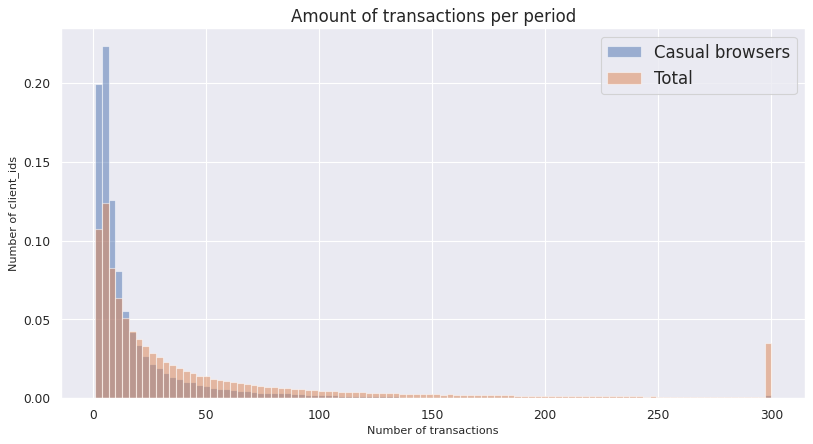

In [21]:
hits_2 = emb_short[emb_short["cluster"] == 1]['hits']
hits_7 = emb_short[emb_short["cluster"] == 4]['hits']
totals = emb_short['hits']

upper_clip = 300

sns.set_theme()
plt.figure(figsize=(12, 6), dpi=80)
_, bins, _ = plt.hist(hits_2.clip(upper=upper_clip), bins=100, alpha=0.5, label='Casual browsers', weights=np.ones(hits_2.shape[0])/hits_2.shape[0])
# plt.hist(hits_7.clip(upper=upper_clip), bins=bins, alpha=0.5, label='Logged buyers hits', weights=np.ones(hits_7.shape[0])/hits_7.shape[0])
plt.hist(totals.clip(upper=upper_clip), bins=bins, alpha=0.5, label='Total', weights=np.ones(totals.shape[0])/totals.shape[0])
plt.legend(loc='upper right', prop={'size': 15})
plt.xlabel('Number of transactions', fontsize=10)
plt.ylabel('Number of client_ids', fontsize=10)
plt.title("Amount of transactions per period", fontsize=15)

plt.show()

In [22]:
emb_gr = emb_short.groupby(["cluster", "is_user"]).client_id.count().reset_index()

clusters_users = pd.pivot_table(emb_gr, index=["cluster"],
                                 columns=["is_user"], values="client_id", fill_value=0)\
    .reset_index()

clusters_users.columns = ["cluster", "non_user", "user"]
clusters_users["user_ratio"] = round(clusters_users["user"]/(clusters_users["user"] + clusters_users["non_user"]), 2)

clusters_users

,cluster,non_user,user,user_ratio
0,0,127915,5345,0.04
1,1,120458,9860,0.08
2,2,61548,2934,0.05
3,3,35585,20851,0.37
4,4,41668,2216,0.05
5,5,8538,33949,0.80


In [23]:
device_type = devices_user[["client_id", "desktop", "mobile", "tablet"]]

In [24]:
# preparing needed columns
##TODO make it into the function

clusters_pages = emb_short.drop(columns=["is_user", "hits", "hits_watches", "days_active", "hits_per_day", "watches_hits_ratio"])\
    .merge(pages_user, on="client_id", how="inner")
T_clusters_pages = clusters_pages.groupby("cluster").sum().T

clusters_events = emb_short.drop(columns=["is_user", "hits", "hits_watches", "days_active", "hits_per_day", "watches_hits_ratio"])\
    .merge(events_user, on="client_id", how="outer")
T_clusters_events = clusters_events.groupby("cluster").sum().T

clusters_device_type = emb_short.drop(columns=["is_user", "hits", "hits_watches", "days_active", "hits_per_day", "watches_hits_ratio"])\
    .merge(devices_user, on="client_id", how="outer")

columns_os_mask = (~clusters_device_type.columns.str.contains("Android"))\
                   & (~clusters_device_type.columns.str.contains("iOS"))\
                   & (~clusters_device_type.columns.str.contains("OS"))\
                   & (~clusters_device_type.columns.str.contains("FreeBSD"))\
                   & (~clusters_device_type.columns.str.contains("Linux"))\
                   & (~clusters_device_type.columns.str.contains("Macintosh"))\
                   & (~clusters_device_type.columns.str.contains("Windows"))\
                   & (~clusters_device_type.columns.str.contains("Tizen"))

T_clusters_device_type = clusters_device_type[["client_id", "cluster", "desktop", "mobile", "tablet"]]\
    .groupby("cluster").sum().T

T_clusters_device_os = clusters_device_type.loc[:, (clusters_device_type.columns.str.contains("cluster")) |\
    (~columns_os_mask\
    & (~clusters_device_type.columns.isin(["desktop", "mobile", "tablet", "os_unknown"])))]\
    .groupby("cluster").sum().T

T_clusters_device_brand = clusters_device_type.loc[:, columns_os_mask\
    & (~clusters_device_type.columns.isin(["desktop", "mobile", "tablet", "os_unknown"]))]\
    .groupby("cluster").sum().T

clusters_tags = emb_short.drop(columns=["is_user", "hits", "hits_watches", "days_active", "hits_per_day", "watches_hits_ratio"])\
    .merge(tags_user, on="client_id", how="outer")
T_clusters_tags = clusters_tags.groupby("cluster").sum().T

In [25]:
purchases = clusters_events[["cluster", "purchase"]].copy()
purchases["was_purch"] = purchases["purchase"]
purchases.loc[purchases["was_purch"] != 0, "was_purch"] = 1
purchases

,cluster,purchase,was_purch
0,2,0,0
1,1,0,0
2,3,0,0
3,5,0,0
4,0,0,0
...,...,...,...
470862,1,0,0
470863,0,0,0
470864,1,0,0
470865,1,0,0


In [54]:
purchases.groupby(["cluster"]).agg({"purchase": ["sum", "count"], "was_purch": "sum"})

purchase         was_purch
             sum   count       sum
cluster                           
0           4895  133260      4719
1           1185  130318      1129
2            865   64482       816
3           1367   56436      1309
4           1714   43884      1582
5          20648   42487     16676

In [59]:
clusters_buying = T_clusters_events_ratio\
    .T[["add_payment_info", "add_shipping_info", "add_to_cart", "begin_checkout", "checkout_progress", "purchase"]]
clusters_buying

,add_payment_info,add_shipping_info,add_to_cart,begin_checkout,checkout_progress,purchase
cluster,,,,,,
cluster_0_rat,0.102994,0.112314,0.795655,0.094590,0.461384,0.036733
cluster_1_rat,0.027540,0.031991,0.256595,0.001688,0.141746,0.009093
cluster_2_rat,0.027930,0.037359,0.397801,0.014438,0.165364,0.013415
cluster_3_rat,0.078088,0.084963,0.356439,0.023513,0.398363,0.024222
cluster_4_rat,0.066744,0.085270,0.761849,0.054074,0.362478,0.039058
cluster_5_rat,1.121802,1.315320,5.348766,1.180079,4.904606,0.485984
Total_rat,0.157397,0.182570,0.947021,0.143552,0.716529,0.065144


In [60]:
clusters_buying_rat = clusters_buying[["purchase"]].copy()

for col in clusters_buying.columns:
    clusters_buying_rat[f"ratio_{col}"] = clusters_buying[col]/clusters_buying["add_to_cart"]
clusters_buying_rat = clusters_buying_rat.drop(columns=["purchase"])
clusters_buying_rat_s = clusters_buying_rat.T.sort_values(by="cluster_0_rat", ascending=False).T
clusters_buying_rat_s

,ratio_add_to_cart,ratio_checkout_progress,ratio_add_shipping_info,ratio_add_payment_info,ratio_begin_checkout,ratio_purchase
cluster,,,,,,
cluster_0_rat,1.0,0.579879,0.141159,0.129446,0.118883,0.046167
cluster_1_rat,1.0,0.552409,0.124675,0.107330,0.006579,0.035438
cluster_2_rat,1.0,0.415695,0.093914,0.070212,0.036295,0.033722
cluster_3_rat,1.0,1.117618,0.238367,0.219079,0.065967,0.067956
cluster_4_rat,1.0,0.475787,0.111925,0.087608,0.070978,0.051267
cluster_5_rat,1.0,0.916960,0.245911,0.209731,0.220626,0.090859
Total_rat,1.0,0.756614,0.192783,0.166202,0.151583,0.068788


In [26]:
# renaming the columns
##TODO make it into the function

i = 0
for col in T_clusters_pages.columns:
    T_clusters_pages = T_clusters_pages.rename(columns={col: f"cluster_{i}"})
    i += 1

i = 0
for col in T_clusters_events.columns:
    T_clusters_events = T_clusters_events.rename(columns={col: f"cluster_{i}"})
    i += 1
    
i = 0
for col in T_clusters_device_type.columns:
    T_clusters_device_type = T_clusters_device_type.rename(columns={col: f"cluster_{i}"})
    i += 1

i = 0
for col in T_clusters_device_os.columns:
    T_clusters_device_os = T_clusters_device_os.rename(columns={col: f"cluster_{i}"})
    i += 1

i = 0
for col in T_clusters_device_brand.columns:
    T_clusters_device_brand = T_clusters_device_brand.rename(columns={col: f"cluster_{i}"})
    i += 1
    
i = 0
for col in T_clusters_tags.columns:
    T_clusters_tags = T_clusters_tags.rename(columns={col: f"cluster_{i}"})
    i += 1

In [27]:
cl_size = list(emb_short.groupby(["cluster"]).client_id.count())
cl_size.append(emb_short.groupby(["cluster"]).client_id.count().sum())

In [28]:
if "Total" in T_clusters_tags.columns:
    T_clusters_tags = T_clusters_tags.drop(columns="Total")
T_clusters_tags["Total"] = T_clusters_tags.sum(axis=1)
T_clusters_tags_ratio = T_clusters_tags.copy()
i = 0
for col in T_clusters_tags.columns:
    T_clusters_tags_ratio[f"{col}_rat"] = T_clusters_tags_ratio[col]/cl_size[i]
    T_clusters_tags_ratio = T_clusters_tags_ratio.drop(columns=[col])
    i += 1

In [29]:
T_clusters_tags_ratio.sort_values(by="cluster_0_rat", ascending=False).head(30)

cluster,cluster_0_rat,cluster_1_rat,cluster_2_rat,cluster_3_rat,cluster_4_rat,cluster_5_rat,Total_rat
trade-in,0.757744,0.274168,0.366242,1.029254,0.403929,4.748135,0.929921
buy now,0.260483,0.083480,0.173816,0.047186,0.190525,0.679243,0.205328
carousel:arrow:right,0.196233,0.020527,0.252970,0.091396,0.370705,1.164097,0.246401
trade in:step1:continue,0.188211,0.065801,0.059660,0.275569,0.037622,0.850354,0.192910
view more,0.166179,0.072200,0.252815,1.319991,0.401604,1.984113,0.476300
colour:graphite,0.163185,0.060890,0.076766,0.050269,0.093291,0.432791,0.127318
trade in:step2:continue,0.131975,0.041959,0.038321,0.169838,0.023220,0.652717,0.135626
samsung care:no,0.131262,0.034347,0.044896,0.028014,0.027049,0.389296,0.093808
colour:silver,0.121769,0.042442,0.058342,0.021777,0.089531,0.306047,0.092767
product click,0.113650,0.046686,0.078487,0.036572,0.114028,0.314473,0.099219


In [58]:
if "Total" in T_clusters_events.columns:
    T_clusters_events = T_clusters_events.drop(columns="Total")
T_clusters_events["Total"] = T_clusters_events.sum(axis=1)
T_clusters_events_ratio = T_clusters_events.copy()
i = 0
for col in T_clusters_events.columns:
    T_clusters_events_ratio[f"{col}_rat"] = T_clusters_events_ratio[col]/cl_size[i]
    T_clusters_events_ratio = T_clusters_events_ratio.drop(columns=[col])
    i += 1

In [99]:
T_clusters_events_ratio.sort_values(by="cluster_3_rat", ascending=False).head(30)

cluster,cluster_0_rat,cluster_1_rat,cluster_2_rat,cluster_3_rat,cluster_4_rat,cluster_5_rat,Total_rat
page_view,7.901553,5.156417,11.401787,10.446488,14.490726,62.376539,13.455617
click_others,3.926970,1.653164,4.238299,8.681569,6.909489,31.366159,6.664009
view_item,3.062922,2.145674,3.436230,3.520413,4.959097,15.053852,4.173697
user_engagement,3.297989,2.182584,4.404004,3.337887,6.568476,24.857604,5.395689
click,1.915293,1.248415,3.976397,2.654813,4.796851,18.424789,3.859848
scroll,1.749054,1.261015,2.693108,2.303122,3.391897,16.279121,3.273852
session_start,1.228013,1.461210,1.630610,2.003473,2.436264,9.391367,2.289827
javascript_errors,1.085067,0.774060,1.483267,1.597544,1.853181,14.758609,2.420316
click_nav,1.046533,0.836968,4.451599,1.282160,3.857533,12.753784,2.801417
click_cta,0.783986,0.358554,0.849819,0.727674,1.235758,5.693130,1.153572


In [65]:
if "Total" in T_clusters_pages.columns:
    T_clusters_pages = T_clusters_pages.drop(columns="Total")
T_clusters_pages["Total"] = T_clusters_pages.sum(axis=1)
T_clusters_pages_ratio = T_clusters_pages.copy()
i = 0
for col in T_clusters_pages.columns:
    T_clusters_pages_ratio[f"{col}_rat"] = T_clusters_pages_ratio[col]/cl_size[i]
    T_clusters_pages_ratio = T_clusters_pages_ratio.drop(columns=[col])
    i += 1

In [106]:
T_clusters_pages_ratio.sort_values(by="cluster_0_rat", ascending=False).head(30)

cluster,cluster_0_rat,cluster_1_rat,cluster_2_rat,cluster_3_rat,cluster_4_rat,cluster_5_rat,Total_rat
watches,11.427202,6.579452,13.551394,16.465483,7.175804,37.893803,12.972185
galaxy-watch,9.942061,5.536457,10.691681,4.057676,6.222541,26.726128,9.287935
buy,8.624051,4.425091,6.547858,16.054717,8.623576,47.201356,11.549066
smartphones,3.368318,2.038329,7.120948,3.666153,10.630617,35.951350,7.166669
galaxy-watch5,1.902649,1.127987,1.579790,16.324261,0.761303,14.654836,4.416825
bile,1.438234,0.758207,2.278078,4.696169,1.185535,8.874362,2.402942
galaxy-z-fold4,1.311421,0.868982,1.681275,1.820203,3.255674,14.855273,2.703882
cart,1.192586,0.398855,0.614683,1.170707,1.250684,13.599807,2.016085
galaxy-bespoke,1.187528,0.582329,1.804473,4.499220,0.686036,6.835762,1.964353
checkout,1.039322,0.310095,0.353370,0.847881,0.788784,11.928708,1.679833


In [82]:
if "Total" in T_clusters_device_type.columns:
    T_clusters_device_type = T_clusters_device_type.drop(columns="Total")
T_clusters_device_type["Total"] = T_clusters_device_type.sum(axis=1)
T_clusters_device_type_ratio = T_clusters_device_type.copy()

for col in T_clusters_device_type.columns:
    T_clusters_device_type_ratio[f"{col}_rat"] = T_clusters_device_type_ratio[col]/T_clusters_device_type_ratio[col].sum()
    T_clusters_device_type_ratio = T_clusters_device_type_ratio.drop(columns=[col])
    

In [83]:
T_clusters_device_type_ratio

cluster,cluster_0_rat,cluster_1_rat,cluster_2_rat,cluster_3_rat,cluster_4_rat,cluster_5_rat,Total_rat
desktop,0.548156,0.000539,0.183800,0.100998,0.380278,0.468584,0.357627
mobile,0.414947,0.989229,0.781218,0.862682,0.577602,0.492709,0.607099
tablet,0.036897,0.010232,0.034982,0.036320,0.042120,0.038707,0.035274


In [84]:
if "Total" in T_clusters_device_brand.columns:
    T_clusters_device_brand = T_clusters_device_brand.drop(columns="Total")
T_clusters_device_brand["Total"] = T_clusters_device_brand.sum(axis=1)
T_clusters_device_brand_ratio = T_clusters_device_brand.copy()
for col in T_clusters_device_brand.columns:
    T_clusters_device_brand_ratio[f"{col}_rat"] = T_clusters_device_brand_ratio[col]/T_clusters_device_brand_ratio[col].sum()
    T_clusters_device_brand_ratio = T_clusters_device_brand_ratio.drop(columns=[col])

In [85]:
T_clusters_device_brand_ratio.sort_values(by="cluster_5_rat", ascending=False).head(30)

cluster,cluster_0_rat,cluster_1_rat,cluster_2_rat,cluster_3_rat,cluster_4_rat,cluster_5_rat,Total_rat
Samsung,0.334195,0.891780,0.606127,0.802893,0.462998,0.424173,0.519460
Google,0.338315,0.003573,0.115794,0.057932,0.236699,0.300324,0.224185
Apple,0.159974,0.069292,0.164634,0.071455,0.148140,0.128060,0.128334
Microsoft,0.103918,0.000339,0.041627,0.029052,0.090252,0.099375,0.075318
Mozilla,0.024517,0.000013,0.007236,0.002325,0.011867,0.018405,0.013989
Huawei,0.005862,0.015119,0.015809,0.007765,0.012374,0.007244,0.009404
OnePlus,0.010345,0.002396,0.014471,0.008013,0.008518,0.005742,0.007734
Opera Software,0.003976,0.000000,0.003216,0.001466,0.003783,0.003972,0.003211
Xiaomi,0.005209,0.008474,0.011441,0.007684,0.007630,0.003581,0.006112
OPPO,0.004024,0.002270,0.005396,0.003744,0.004768,0.003091,0.003677


### RESEARCHING CLUSTER 5

In [41]:
curious = emb_short[emb_short["cluster"] == 0].reset_index(drop=True)
curious

,client_id,is_user,hits,hits_watches,days_active,cluster,hits_per_day,watches_hits_ratio
0,GA1000020196.1660983885,1,90,50,1,0,90.0,0.56
1,GA1000025435.1662974024,1,32,15,2,0,16.0,0.47
2,GA1000043733.1642151402,0,32,9,2,0,16.0,0.28
3,GA100004847.1662491891,0,29,26,2,0,14.5,0.90
4,GA1000050343.1660691333,0,28,1,1,0,28.0,0.04
...,...,...,...,...,...,...,...,...
133255,GA999925781.1663531084,0,21,21,2,0,10.5,1.00
133256,GA999931367.1656591038,0,11,11,1,0,11.0,1.00
133257,GA999977668.1662601586,0,11,11,1,0,11.0,1.00
133258,GA99997774.1660843942,0,23,23,1,0,23.0,1.00


In [42]:
watches_pages = pages_user.filter(regex="client_id|watch")

In [43]:
curious_whatch_pages = curious.merge(watches_pages, on="client_id", how="inner")

In [44]:
curious_whatch_pages

,client_id,is_user,hits,hits_watches,days_active,cluster,hits_per_day,watches_hits_ratio,all-watches,anti-poaching-wildlife-watch,...,watch4-strap,watch5,watch5-pro,watch5-strap,watches,watchstudio,wearables+galaxy-watch3,wearables+galaxy-watch4,wearables+watch-straps,what-does-a-smartwatch-do
0,GA1000020196.1660983885,1,90,50,1,0,90.0,0.56,3,0,...,0,0,0,0,38,0,0,0,0,0
1,GA1000025435.1662974024,1,32,15,2,0,16.0,0.47,0,0,...,0,0,0,0,14,0,0,0,0,0
2,GA1000043733.1642151402,0,32,9,2,0,16.0,0.28,0,0,...,0,0,0,0,6,0,0,0,0,0
3,GA100004847.1662491891,0,29,26,2,0,14.5,0.90,0,0,...,0,0,0,0,15,0,0,0,0,0
4,GA1000050343.1660691333,0,28,1,1,0,28.0,0.04,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133255,GA999925781.1663531084,0,21,21,2,0,10.5,1.00,0,0,...,0,0,0,0,5,0,0,0,0,0
133256,GA999931367.1656591038,0,11,11,1,0,11.0,1.00,6,0,...,0,0,0,0,9,0,0,0,0,0
133257,GA999977668.1662601586,0,11,11,1,0,11.0,1.00,0,0,...,0,0,0,0,9,0,0,0,0,0
133258,GA99997774.1660843942,0,23,23,1,0,23.0,1.00,0,0,...,0,0,0,0,17,0,0,0,0,0


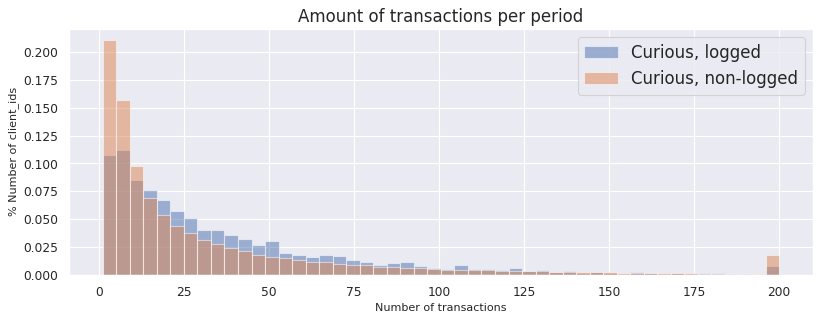

In [49]:
hits_user = curious[curious["is_user"] == 1]['hits']
hits_non = curious[curious["is_user"] == 0]['hits']
totals = curious['hits']

upper_clip = 200

sns.set_theme()
plt.figure(figsize=(12, 4), dpi=80)
_, bins, _ = plt.hist(hits_user.clip(upper=upper_clip), bins=50, alpha=0.5,\
                      label='Curious, logged', weights=np.ones(hits_user.shape[0])/hits_user.shape[0])
plt.hist(hits_non.clip(upper=upper_clip), bins=bins, alpha=0.5,\
         label='Curious, non-logged', weights=np.ones(hits_non.shape[0])/hits_non.shape[0])
# plt.hist(totals.clip(upper=upper_clip), bins=bins, alpha=0.5, label='Total', weights=np.ones(totals.shape[0])/totals.shape[0])
plt.legend(loc='upper right', prop={'size': 15})
plt.xlabel('Number of transactions', fontsize=10)
plt.ylabel('% Number of client_ids', fontsize=10)
plt.title("Amount of transactions per period", fontsize=15)

plt.show()

In [50]:
activity_by_logged = curious.groupby(["is_user"])\
    .agg({"hits": np.median,\
          "hits_watches": np.median,\
          "days_active": np.median,\
          "hits_per_day": np.median,\
          "watches_hits_ratio": np.median})